# DATA UNDERSTANDING #

1. **Building the Dataset**

_1.1 Participants:_
- A lively and very talkative 3.5-month-old male Scottish Fold kitten named Mio served as the primary subject.
- A group of human participants, including myself as a study author and my daughter Kate as a human meow vocalizer.

_1.2 Experimental Contexts:_  

Accompanied by the study author, the kitten was exposed to three distinct contexts aimed at eliciting varied meows:

- Waiting for Food (Condition `F`):  
The author initiated routine morning recordings preceding mealtime, with food delivered after the recordings done.

- Seeking Attention in Isolation (Condition `A`):  
The kitten was placed in an isolated room with ample provisions and signaled its need for attention by meowing at the closed door.

- Thrill (Condition `T`):  
The kitten is purring or slightly meowing while petted and caressed by author in a home environment for 3-5 minutes.

A human participant was limited to a single context while trying to produce all kind of meows:

- Human (Condition `KAT`):  
Randomly producing meows during the experiment.

We included a human to aid the program in recognizing human-like meowing.  
This diverse set of vocalizations allows us predict artificial meows if users want to simulate meowing themselves.  

Typically, vocalizations in a single exposure comprised multiple repeated meows.

2. **Data Acquisition Process**

The experiment spanned 15 days, conducted in the same room, with daily data collection.  
Phone Samsung Note20 equipped with the "Samsung Voice Recorder" app was used as the recording device.  
Each recorded audio file, averaging 1-3 minutes, was converted to .wav format via www.cloudconvert.com.  
Further processing included breaking down each .wav file into individual samples less than 3 seconds.

3. **Dataset Composition:**  

The dataset consists of:

- 96 samples obtained under Condition `F`
- 96 samples obtained under Condition `A`
- 80 samples obtained under Condition `T`
- 98 samples obtained under Condition `KAT`

**Total: 370 audio files**

_Individual sample description:_  

202312071816_T_1.wav,  where
- 2023 = year recorded
- 12 = month recorded
- 07 = day recorded
- 18  = hour (24 hours) recorded
- 16 = minute  recorded
- T = condition recorded
- 1 = number of the sample
- wav = audio format of the sample


# BUSINESS PROBLEM #

Many people decide to get a kitten, but they don't always fully understand what these cute creatures need.  
Games, food or something else?  
And how to find out if they enjoy playing?

This project consists of two key parts:

- **Model for predicting meowing categories:**  
We aim to create a model that accurately determines which category a meow belongs to with the best accuracy score.  
Data processing speed is also an important aspect, influencing the second part of our work.

- **Mobile app for owner training:**  
Based on the model's results, we are developing a mobile app.  
It provides new owners with the opportunity to learn how to understand their furry friends from the very first days in their new home.


**Importing necessary libraries**

In [4]:
import os
import pathlib
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import librosa
import librosa.display
from IPython.display import Audio
plt.rcParams['pcolor.shading'] = 'nearest'
from pydub import AudioSegment
import wave
from scipy.io import wavfile
from pydub.utils import mediainfo

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical 


import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis #

Loading 4 different audio samples of each experimented condition

In [5]:
data_paths = {
    'food': 'dataset/food/202312150718_F_17.WAV',
    'attention': 'dataset/attention/202312051330_A_6.WAV',
    'thrill': 'dataset/thrill/202312111148_T_8.WAV',
    'human': 'dataset/human/202312140742_KAT_K_34.WAV'
}


Checking data type, shape of the audio file and sample rate

In [6]:
for key, value in data_paths.items():
    x, sr = librosa.load(value)
    print(f"Condition: {key}")
    print(f"Type of Audio File: {type(x)}, Type of Sample Rate: {type(sr)}")
    print(f"Shape of Audio File:: {x.shape}, Sample Rate: {sr}")
    print("-------------------------------")

Condition: food
Type of Audio File: <class 'numpy.ndarray'>, Type of Sample Rate: <class 'int'>
Shape of Audio File:: (32093,), Sample Rate: 22050
-------------------------------
Condition: attention
Type of Audio File: <class 'numpy.ndarray'>, Type of Sample Rate: <class 'int'>
Shape of Audio File:: (32054,), Sample Rate: 22050
-------------------------------
Condition: thrill
Type of Audio File: <class 'numpy.ndarray'>, Type of Sample Rate: <class 'int'>
Shape of Audio File:: (40164,), Sample Rate: 22050
-------------------------------
Condition: human
Type of Audio File: <class 'numpy.ndarray'>, Type of Sample Rate: <class 'int'>
Shape of Audio File:: (25704,), Sample Rate: 22050
-------------------------------


Checking properties of audio files

In [7]:
def get_wav_properties(filename):
    with wave.open(filename, 'rb') as wav_file:
        num_channels = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        sample_width = wav_file.getsampwidth()
        num_frames = wav_file.getnframes()
        duration = num_frames / float(sample_rate)
        bit_depth = sample_width * 8  # Sample width is in bytes
    return num_channels, sample_rate, bit_depth, duration


for condition, filepath in data_paths.items():
    num_channels, sample_rate, bit_depth, duration = get_wav_properties(filepath)
    print(f"Condition: {condition}")
    print(f"File: {filepath}")
    print(f"Number of Channels: {num_channels}")
    print(f"Sample Rate: {sample_rate} Hz")
    print(f"Bit Depth: {bit_depth}-bit")
    print(f"Duration: {duration:.2f} seconds")
    print("-------------------------------")

Condition: food
File: dataset/food/202312150718_F_17.WAV
Number of Channels: 1
Sample Rate: 44100 Hz
Bit Depth: 16-bit
Duration: 1.46 seconds
-------------------------------
Condition: attention
File: dataset/attention/202312051330_A_6.WAV
Number of Channels: 1
Sample Rate: 44100 Hz
Bit Depth: 16-bit
Duration: 1.45 seconds
-------------------------------
Condition: thrill
File: dataset/thrill/202312111148_T_8.WAV
Number of Channels: 1
Sample Rate: 44100 Hz
Bit Depth: 16-bit
Duration: 1.82 seconds
-------------------------------
Condition: human
File: dataset/human/202312140742_KAT_K_34.WAV
Number of Channels: 1
Sample Rate: 44100 Hz
Bit Depth: 16-bit
Duration: 1.17 seconds
-------------------------------


Let's play each audio sample

In [8]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    print(f"Condition: {key}")
    display(Audio(x, rate=sr))

Condition: food


Condition: attention


Condition: thrill


Condition: human


Visual inspection of waveform of each sample

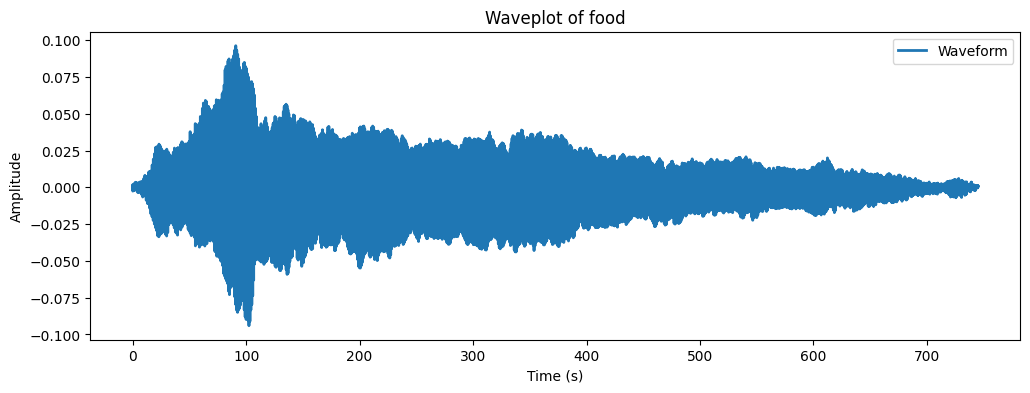

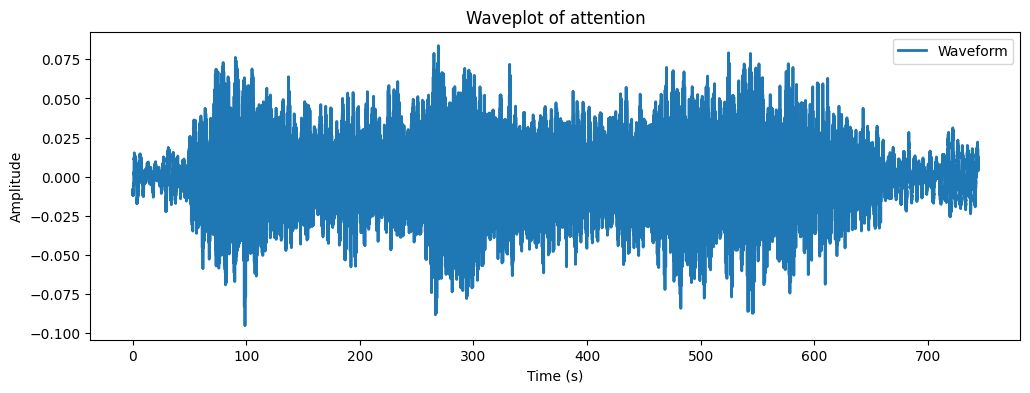

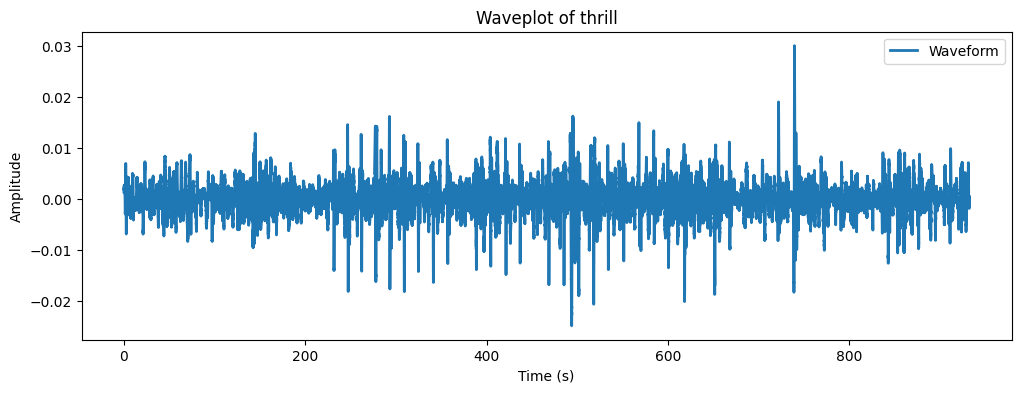

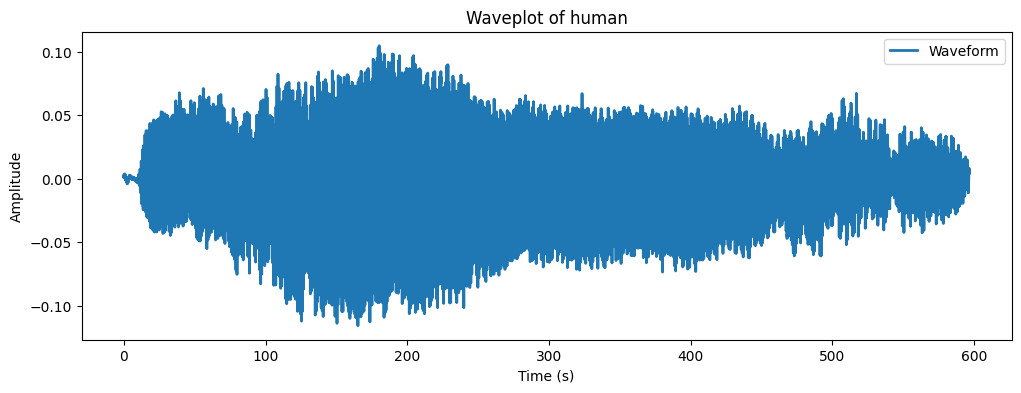

In [9]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Generate time values for the x-axis
    time = librosa.times_like(x, sr=sr)
    
    plt.figure(figsize=(12, 4))
    plt.plot(time, x, label='Waveform', linewidth=2)
    plt.title(f'Waveplot of {key}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

Zooming in on the data

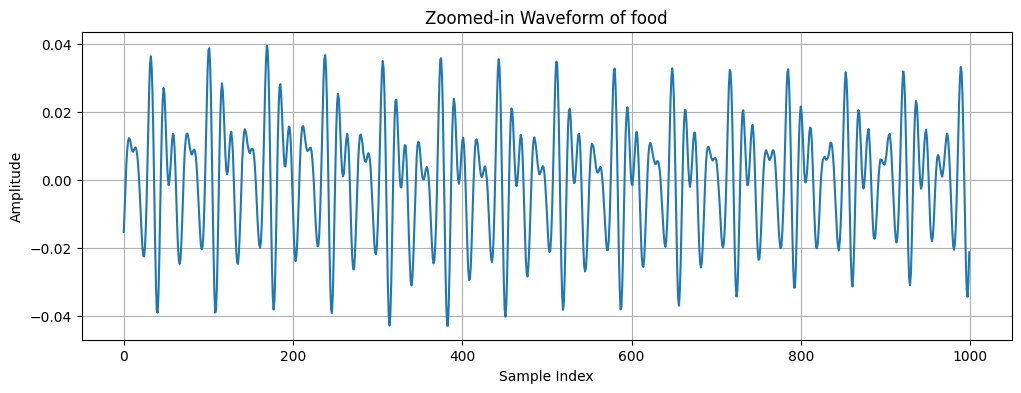

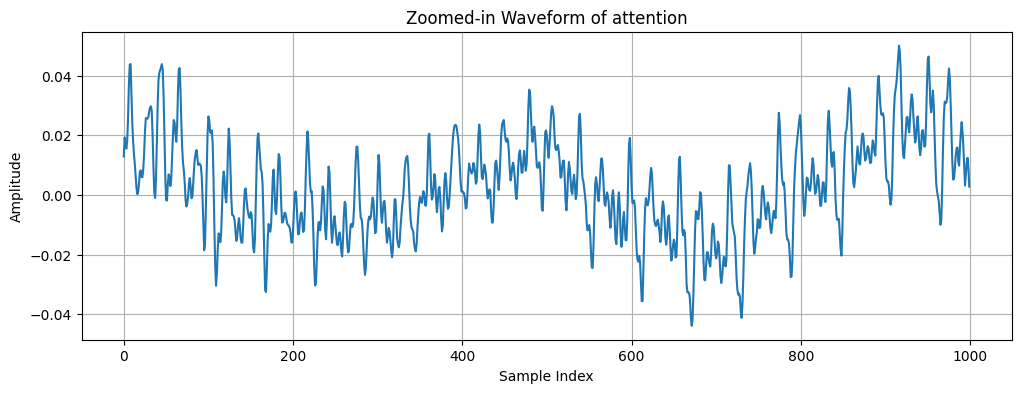

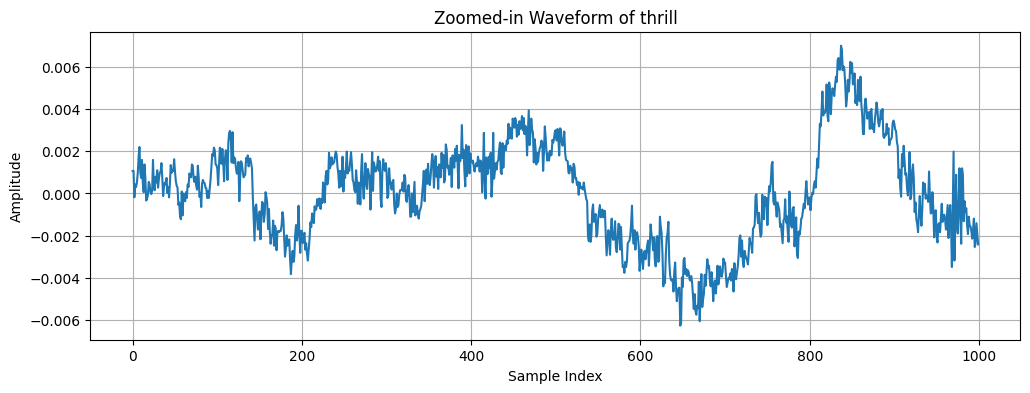

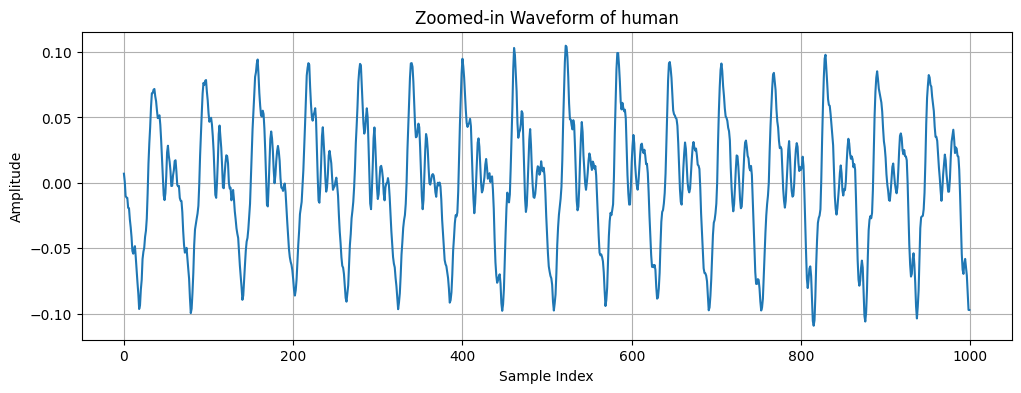

In [10]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Zoom in on a specific range
    n0 = 15000
    n1 = 16000
    plt.figure(figsize=(12, 4))
    plt.plot(x[n0:n1])
    plt.title(f'Zoomed-in Waveform of {key}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

Analyzing the temporal characteristics of the audio signal.  
A higher number of zero-crossings can indicate more rapid changes in the signal,  
which might be associated with certain features like percussive sounds or high-frequency components.

In [11]:
for key, value in data_paths.items():
    # Load audio file
    x, sr = librosa.load(value, sr=44100)

    # Calculate zero-crossings in the zoomed-in range
    zero_crossings = librosa.zero_crossings(x[n0:n1])
    print(f'Zero-Crossing value for {key}: {sum(zero_crossings)}')

Zero-Crossing value for food: 111
Zero-Crossing value for attention: 103
Zero-Crossing value for thrill: 100
Zero-Crossing value for human: 106


Creating a spectrogram to visualize the frequency content of the signal over time  
The color intensity in the spectrogram represents the amplitude of different frequencies at different time points

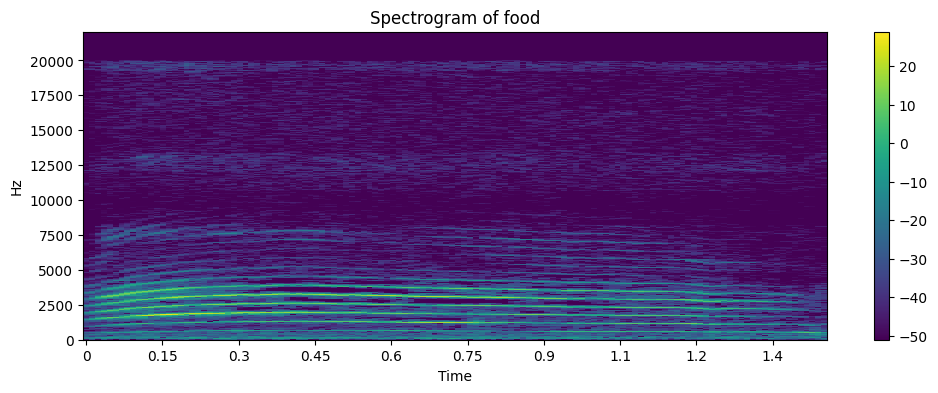

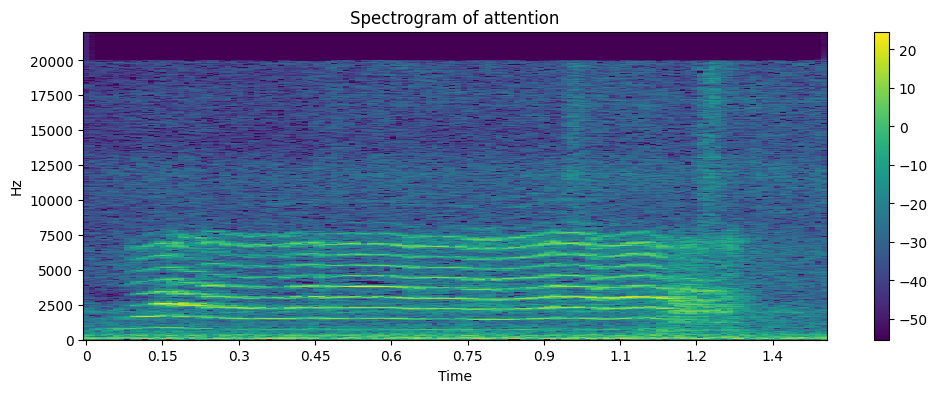

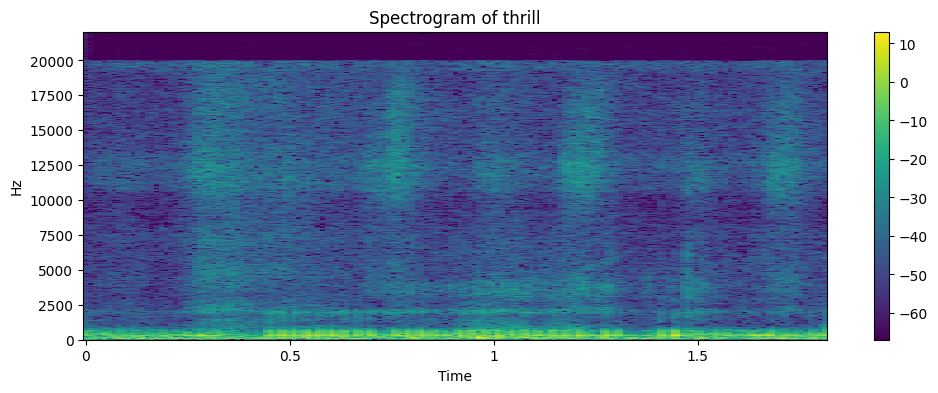

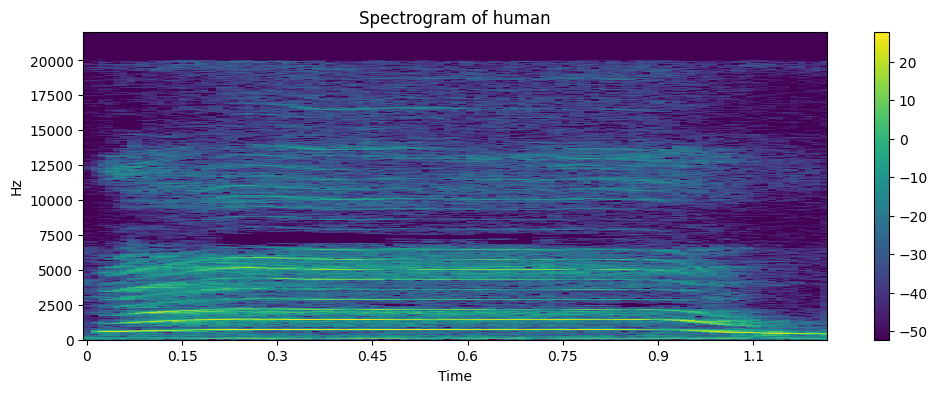

In [12]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='viridis') 
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()


Displaying a spectrogram with a logarithmic frequency scale

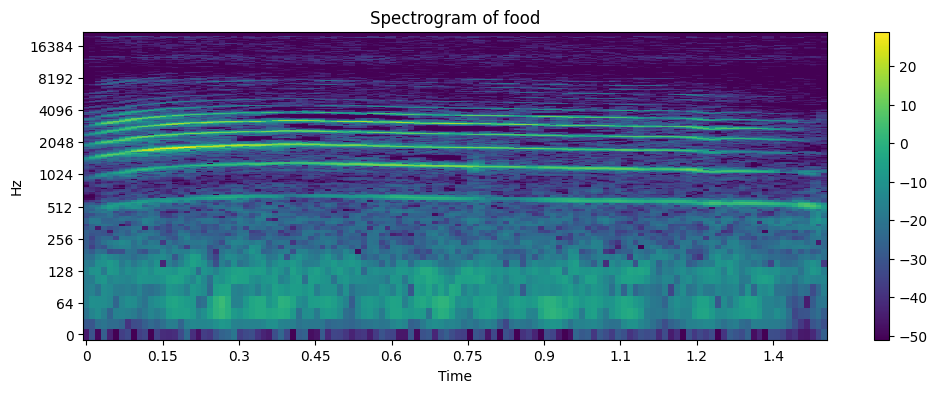

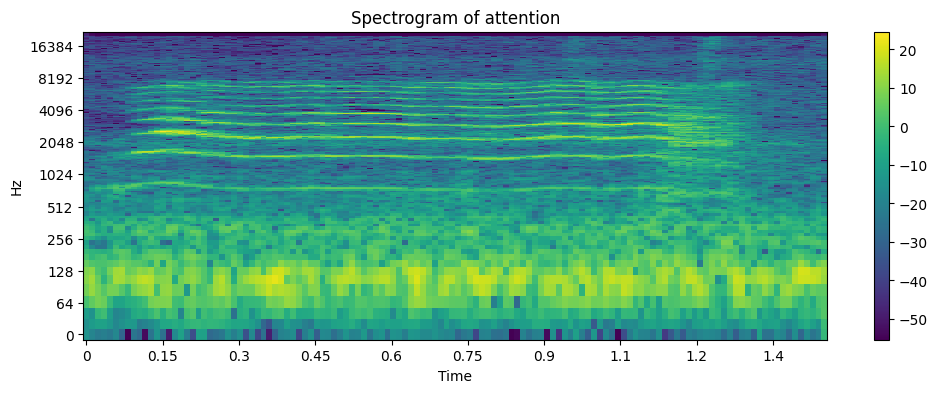

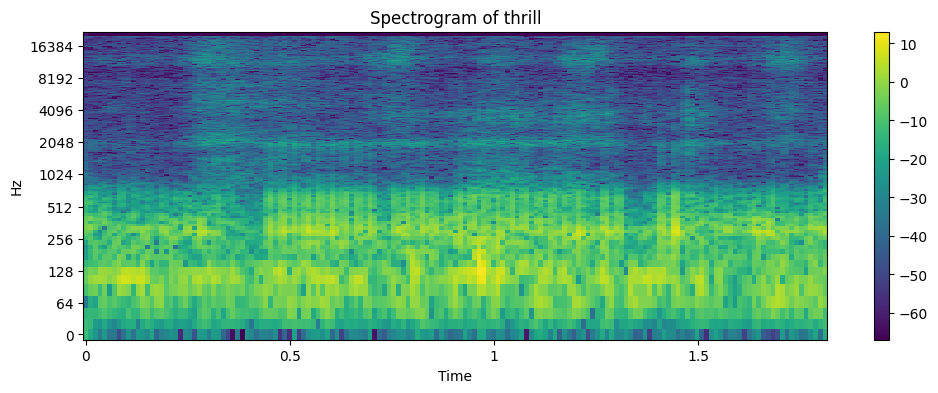

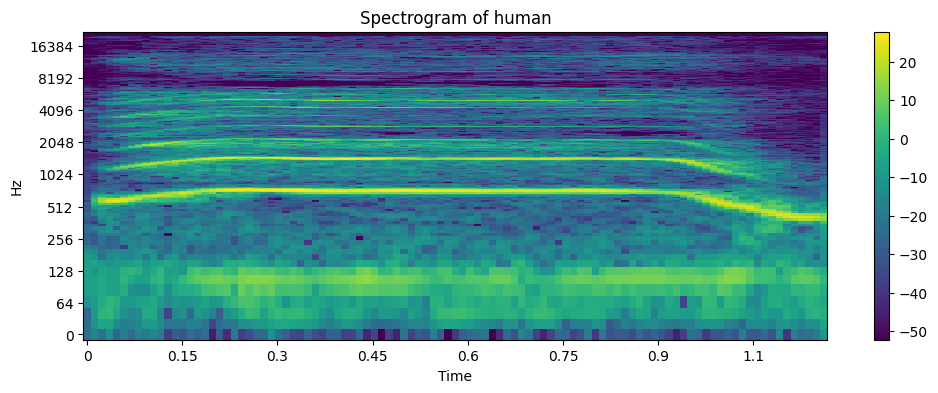

In [13]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()

Visualization of Mel-frequency cepstral coefficients (MFCCs)  

MFCCs are coefficients representing the short-term power spectrum of a sound signal.  

The MFCCs capture the spectral characteristics of the audio signal and are particularly useful for capturing features related to human perception of sound.

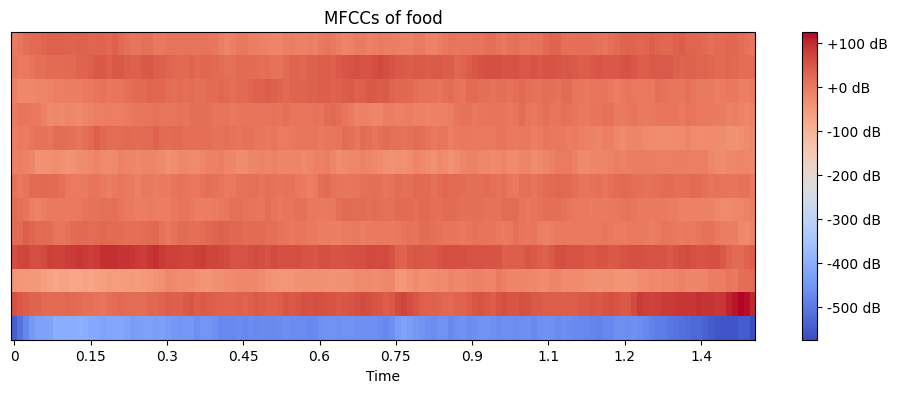

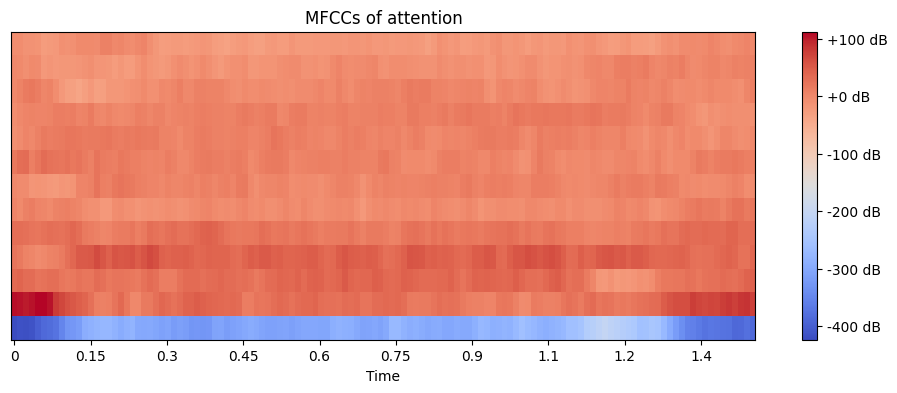

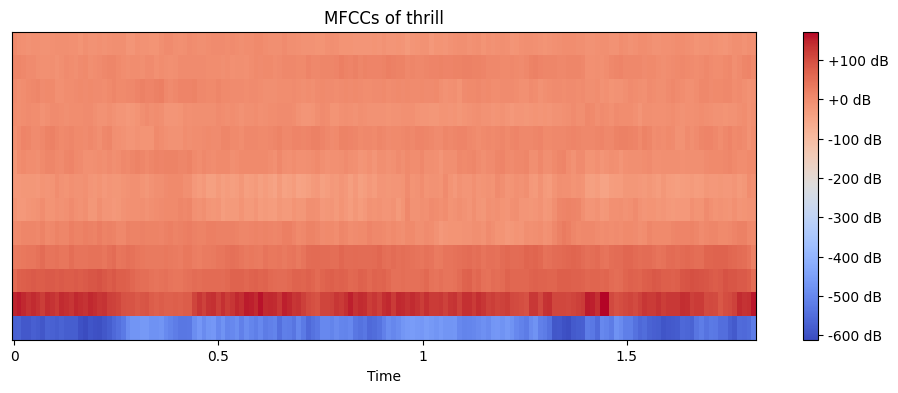

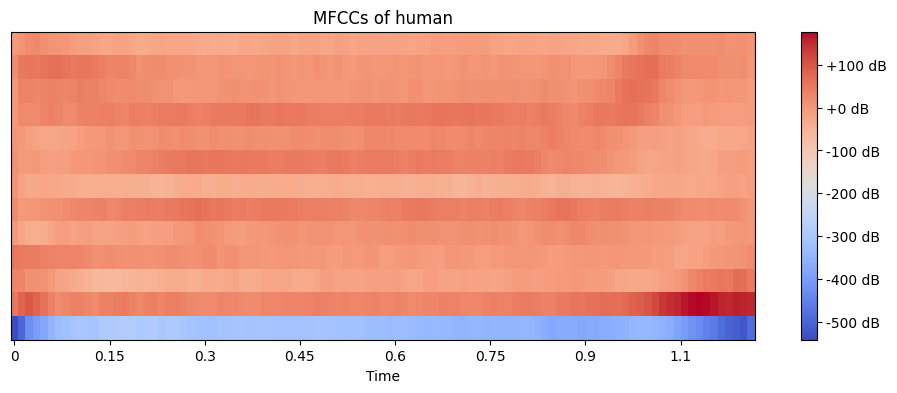

In [14]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the mel spectrogram
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8192)

    # Convert the mel spectrogram to MFCCs
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=13)

    plt.figure(figsize=(12, 4))
    plt.title(f'MFCCs of {key}')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

Generating a chromagram.  
Visual representation of the distribution of pitch content over time in the audio signal.  
The resulting plot is a useful tool for analyzing the harmonic content and tonal characteristics of the audio.

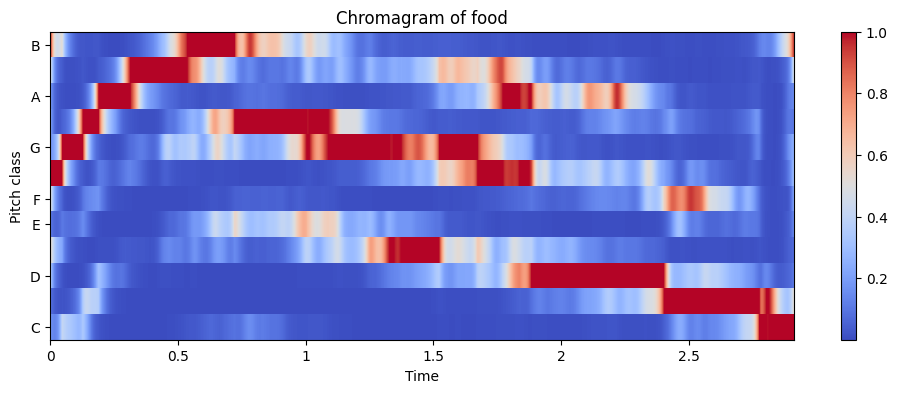

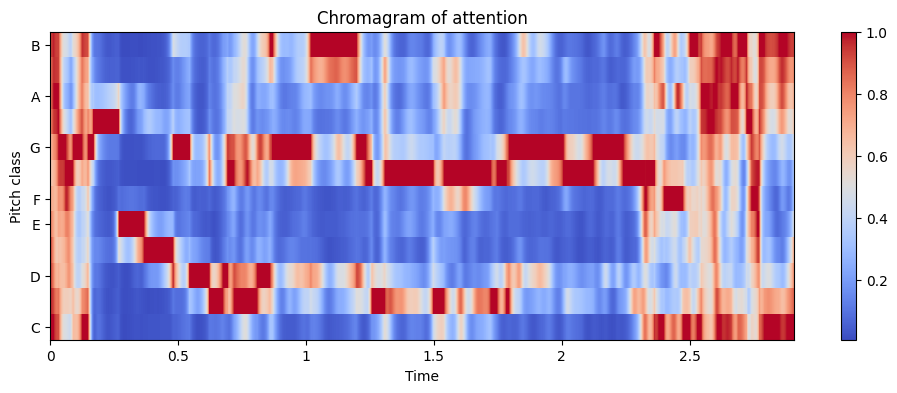

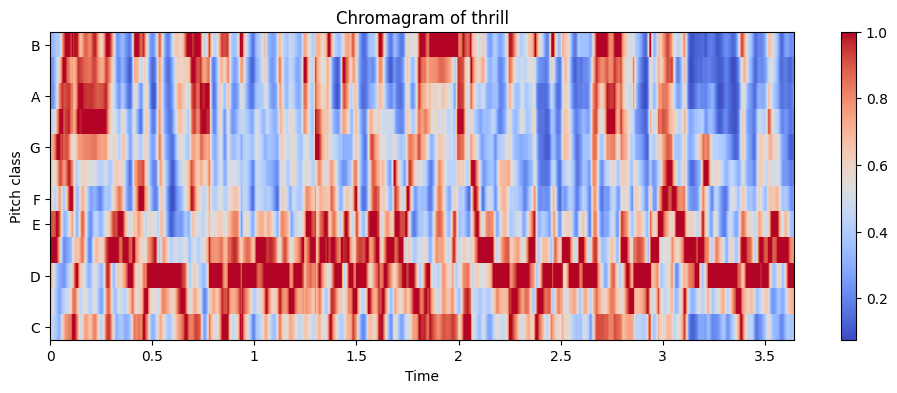

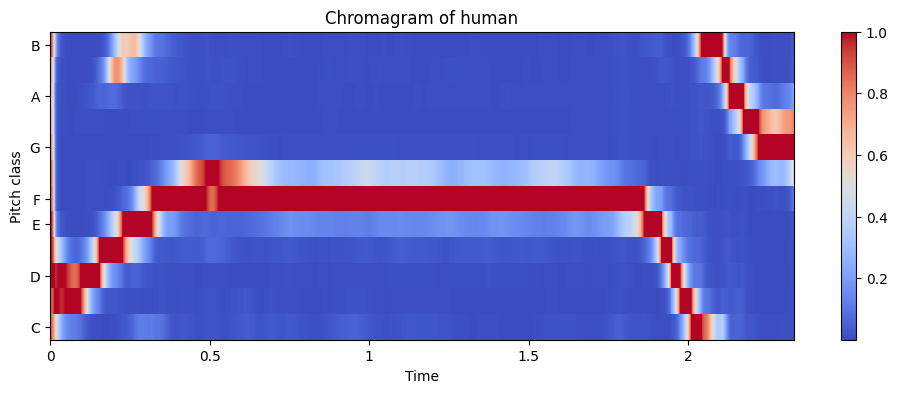

In [15]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)
# Set the hop length
    hop_length = 12

# Compute the chromagram
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title(f"Chromagram of {key}")
    plt.colorbar()
    plt.show()


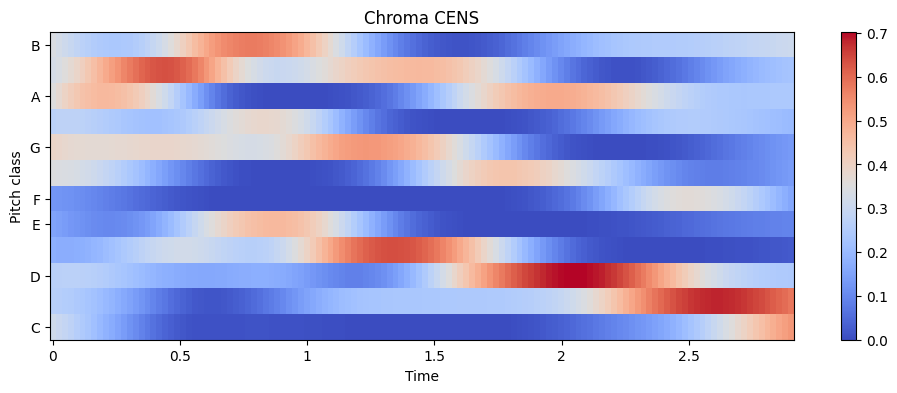

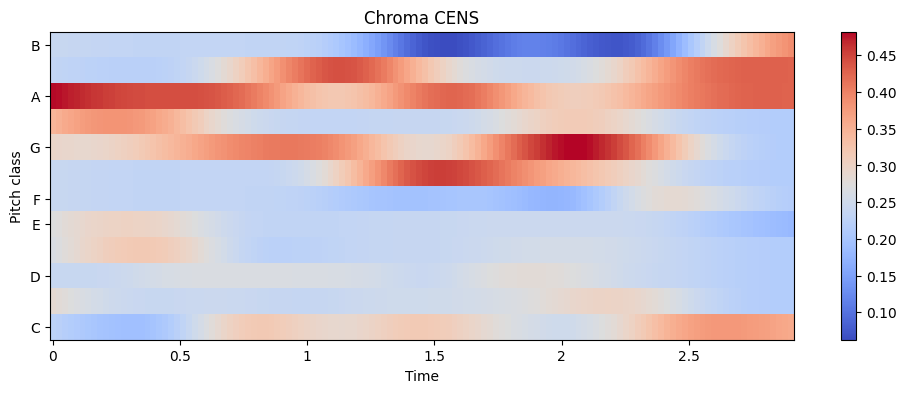

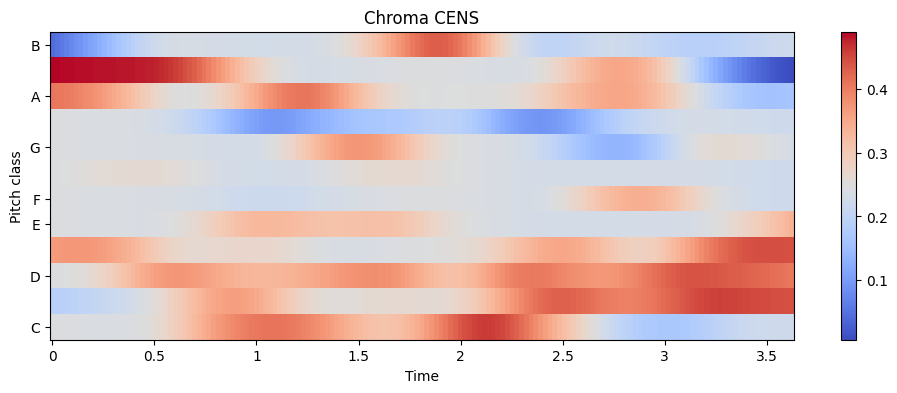

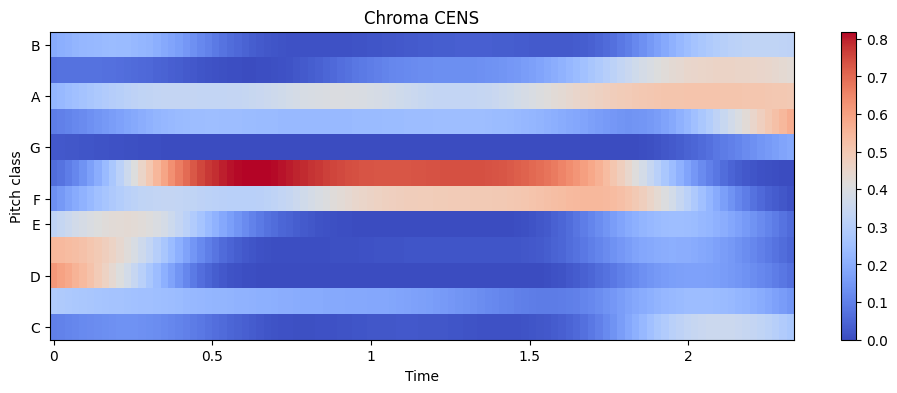

In [16]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)

# Compute the chromagram
    chromagram = librosa.feature.chroma_cens(y=x)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chroma CENS')
    plt.show()

Summary:

## Loading Dataset ##


Extracting the Spectrogram for every audio file

In [17]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
conditions = 'attention food thrill human'.split()
for index in conditions:
    pathlib.Path(f'img_data/{index}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'dataset/{index}'):
        name = f'dataset/{index}/{filename}'
        y, sr = librosa.load(name, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{index}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 800x800 with 0 Axes>

Creating a header for CSV file with names of the features we are going to extract

In [44]:
header = 'filename chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Extracting features from Spectrogram:  
- Root Mean Square (RMS) Energy
- Chroma Frequencies
- Spectral Centroid 
- Spectral Bandwidth
- Spectral Roll-off
- Zero Crossing Rate
- Mel-frequency cepstral coefficients (MFCC)

In [45]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
conditions = 'attention food thrill human'.split()
for index in conditions:
    for filename in os.listdir(f'dataset/{index}'):
        name = f'dataset/{index}/{filename}'
        y, sr = librosa.load(name, mono=True, duration=5)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {index}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Data preprocessing: It involves loading CSV data, label encoding, feature scaling and data split into training and test set.

In [46]:
df = pd.read_csv('dataset.csv')
df.head()

,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,202312051330_A.WAV,0.504191,0.009287,2054.607526,2653.845144,5265.594002,0.065347,-356.701904,98.411255,18.742775,...,-2.455895,-4.249054,-12.475314,-9.818407,-8.676962,-1.923811,-8.112579,-6.865637,6.373342,attention
1,202312051330_A_1.WAV,0.256010,0.033934,2752.580450,2112.850780,4841.157532,0.185903,-290.921051,56.904606,-16.373430,...,-28.444410,-16.924181,-12.909103,2.788969,-2.945886,-12.325088,-3.512870,19.030312,-1.950980,attention
2,202312051330_A_2.WAV,0.393909,0.008960,1697.073768,2445.346826,4361.633113,0.053035,-403.959351,104.384109,34.298668,...,1.747297,-1.852686,-12.306437,-12.263917,-7.928906,0.309319,-7.690095,-8.052268,8.894715,attention
3,202312051330_A_3.WAV,0.301483,0.017562,2663.642315,2268.093438,5117.948914,0.161001,-306.031647,66.317566,-16.575302,...,-3.921827,-4.831570,-19.400209,-13.472499,-0.037829,-2.397462,-16.758034,-6.215157,12.740056,attention
4,202312051330_A_4.WAV,0.333023,0.018588,2373.669763,2241.234783,4524.457257,0.138547,-327.634552,76.739761,-11.213006,...,-21.986101,-9.556071,-0.231299,0.693724,-4.100849,-4.416086,-1.575086,1.350910,-4.962408,attention


Dropping filename column

In [47]:
df = df.drop(['filename'],axis=1)

Splitting the data into training and testing sets

In [48]:
y = df['label']
X = df.drop(['label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [49]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print(encoded_y_train.shape)
print(encoded_y_test.shape)

(296,)
(74,)


In [50]:
# converting integer-encoded class labels to one-hot encoded format
num_classes_in_dataset = len(label_encoder.classes_)
y_train_one_hot = to_categorical(encoded_y_train, num_classes=num_classes_in_dataset)
y_test_one_hot = to_categorical(encoded_y_test, num_classes=num_classes_in_dataset)

In [51]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building a model

In [74]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Dense(num_classes_in_dataset))
model.add(Activation('softmax'))

# model = Sequential()
# model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

Compile the model


In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [76]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               6912      
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 activation_13 (Activation)  (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 4)                 516       
                                                                 
 activation_14 (Activation)  (None, 4)                 0         
                                                                 
Total params: 40324 (157.52 KB)
Trainable params: 4032

In [77]:
model_train = model.fit(X_train_scaled, y_train_one_hot, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test_scaled, y_test_one_hot),
                    verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 10ms/step - loss: 1.1172 - accuracy: 0.6115 - val_loss: 0.8396 - val_accuracy: 0.7027
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5285 - accuracy: 0.8682 - val_loss: 0.5717 - val_accuracy: 0.8108
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.3472 - accuracy: 0.8953 - val_loss: 0.4565 - val_accuracy: 0.8243
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2552 - accuracy: 0.9122 - val_loss: 0.4024 - val_accuracy: 0.8378
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1978 - accuracy: 0.9426 - val_loss: 0.3868 - val_accuracy: 0.8378
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1599 - accuracy: 0.9595 - val_loss: 0.3605 - val_accuracy: 0.8514
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1332 - accuracy: 0.9730 - val_loss: 0.3359 - val_accuracy: 0.8784
Epoch 8/100


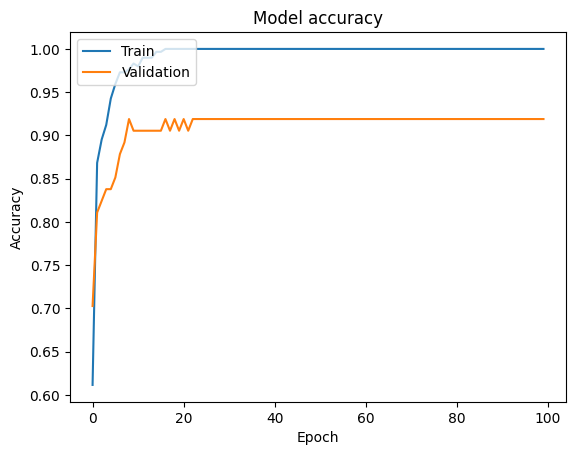

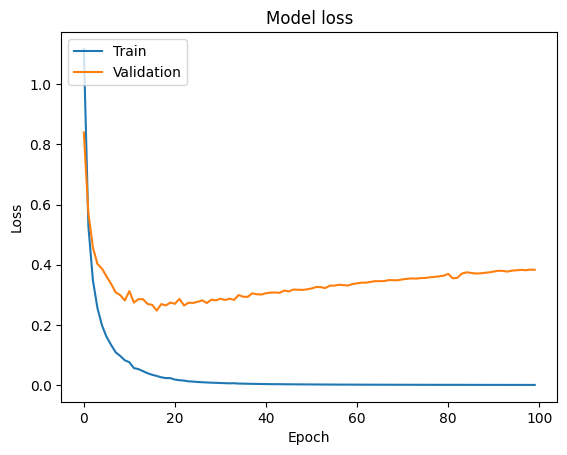

In [78]:
# Plot training & validation accuracy values
plt.plot(model_train.history['accuracy'])
plt.plot(model_train.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Test the model

In [79]:
# Evaluating the model on the training and testing set
score_train = model.evaluate(X_train_scaled, y_train_one_hot, verbose=0)
print("Training Accuracy: ", score_train[1])

score_test = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print("Testing Accuracy: ", score_test[1])


Training Accuracy:  1.0
Testing Accuracy:  0.9189189076423645


Predictions
